In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install --quiet --upgrade tensorflow-federated==0.20.0

In [ ]:
#hadamard_path = '/content/drive/MyDrive/secure_frequency_estimation/hadamard_response-master/'
#import sys
#sys.path.insert(0, hadamard_path)

%cd /content/drive/MyDrive/secure_frequency_estimation/hadamard_response-master/

/content/drive/MyDrive/secure_frequency_estimation/hadamard_response-master


In [ ]:
%matplotlib inline
#import Classic
import RR_RAPPOR
import Subsetselection
import k2k_hadamard
import timeit
import scipy.io as io
import datetime

import numpy as np
import random
import math
import matplotlib.pyplot as plt
import scipy.io as io
from functions import *
from sympy import fwht
from scipy.special import betaln
from scipy.special import logsumexp
import matplotlib.pyplot as plt
import math
from scipy import optimize
from scipy import special

import tensorflow as tf
import tensorflow_privacy as tfp

# Count-sketch implementation

In [ ]:
def count_sketch(x, hashedIndices, randSigns, w):

  t = hashedIndices.shape[0]
  d = x.shape[0]

  sketch = np.zeros((t, w))

  for i in range(t):
    x_signed = x*randSigns[i]
    for j in range(w):
      indices = (hashedIndices[i] == j)
      sketch[i, j] = np.sum(x_signed[indices])
  return sketch

def unsketch(sketch, hashedIndices, randSigns):

  t = hashedIndices.shape[0]
  d = hashedIndices.shape[1]

  unsketch = np.zeros((t, d))
  for i in range(t):
    unsketch[i,:] = sketch[i, hashedIndices[i]]*randSigns[i]
  return unsketch

# Skellatch

In [ ]:
class skellatch:
  def __init__(self, absz, eps, w, t):
    self.absz = absz
    self.eps = eps
    self.delta = 10**-5
    # Padding w
    self.w = 2**(int(np.log2(w)))
    self.t = t
    self.hashedIndices = np.random.choice(w, (t, absz), replace=True)
    self.randSigns = np.random.choice(2, (t, absz), replace=True) * 2 - 1
    self.noise_variance = (2.5 * t * np.log(1.25/self.delta))/(eps**2)
    self.poi_variance = self.noise_variance/2
  
  def encode_string(self, samples):
    # Compute the histogram
    histogram, _ = np.histogram(samples, np.arange(self.absz+1))

    # Apply count-sketch with new hash functions
    self.hashedIndices = np.random.choice(self.w, (self.t, self.absz), replace=True)
    self.randSigns = np.random.choice(2, (self.t, self.absz), replace=True) * 2 - 1

    sketch = count_sketch(histogram, self.hashedIndices, self.randSigns, self.w)
    sketch_flattened = sketch

    # Add Skellam noise
    Skellam_noise = np.random.poisson(lam=self.poi_variance, 
                                        size=(self.t, self.w))
    Skellam_noise -= np.random.poisson(lam=self.poi_variance, 
                                        size=(self.t, self.w))
    #print(Skellam_noise[:5, :5])
    noisy_sketch = sketch + Skellam_noise
    #noisy_sketch = sketch

    return noisy_sketch

  def decode_string(self, sketch, n=0):
    # unsketch the noisy sketch
    unsketched = unsketch(sketch, self.hashedIndices, self.randSigns)
    #threshold = n*5/self.w
    #unsketched = unsketched * (unsketched > threshold)
    return np.median(unsketched, axis=0)

# PBM accounting tools

In [ ]:
# PBM rdp

def binomln(n, k): 
  '''
  Log of scipy.special.binom calculated entirely in the log domain
  '''
  return -betaln(1 + n - k, 1 + k) - np.log(n + 1)

def log_comb(n, k):
  '''
  Log of {n \choose k}
  '''
  gammaln = special.gammaln
  return gammaln(n + 1) - gammaln(k + 1) - gammaln(n - k + 1)

def log_sum_of_product(log_p1, log_p2):
  """
  Compute p_1*q_1+...+p_n*q_n in the log space
  """
  return logsumexp(log_p1+log_p2)


def convolutionln(log_p1, log_p2):
  """
  Compute log(convolution(p1, p2))
  """
  if len(log_p1) > len(log_p2):
    log_p1, log_p2 = log_p2, log_p1
  l1 = len(log_p1)
  l2 = len(log_p2)

  out = np.array([-10.0**10]*(l1+l2-1))
  log_p1_inv = log_p1[::-1]
  for i in range(l1):
    #print(out[i:i+l2])
    out[i:i+l2] = logsumexp(np.stack((out[i:i+l2], log_p2+log_p1[i])), axis=0)
  #print(np.exp(out))
  return out

def gen_log_binomial(n, p):
  return np.array([binomln(n, k)+k*np.log(p)+(n-k)*np.log(1-p) for k in range(n+1)])

def pbm_rdp_scalar(n, m, theta, alpha, d=1):
  log_p1 = gen_log_binomial(n*m, 1/2-theta)
  log_p2_a = gen_log_binomial((n-1)*m, 1/2-theta)
  log_p2_b = gen_log_binomial(m, 1/2+theta)
  log_p2 = convolutionln(log_p2_a, log_p2_b)
  rdp = logsumexp(alpha*log_p1-(alpha-1)*log_p2)

  return rdp/(alpha-1)*d

def pbm_rdp(n, m, theta, alpha, d=1):
  log_p1 = gen_log_binomial(n*m, 1/2-theta)
  log_p2_a = gen_log_binomial((n-1)*m, 1/2-theta)
  log_p2_b = gen_log_binomial(m, 1/2+theta)
  log_p2 = convolutionln(log_p2_a, log_p2_b)
  llr = np.outer(alpha, log_p1) - np.outer(alpha-1, log_p2)
  rdp = logsumexp(llr, axis=1)

  return rdp/(alpha-1)*d

def pbm_rdp_fast(n, m, theta, alpha, d=1):
  return m*(pbm_rdp(n, 1, theta, alpha, d))



In [ ]:
RDP_ORDERS = np.array(list(range(2, 129)) + [256.])

def get_pbm_eps(n, m, theta, d, target_delta=1e-5, orders=RDP_ORDERS):
  rdps = pbm_rdp_fast(n=n, m=m, theta=theta, d=d, alpha = orders)
  eps, _, order = tfp.get_privacy_spent(orders, rdps, 
                                      target_delta=target_delta)
  return eps

#eps = get_pbm_eps(n=1000, m=10, theta=0.016695, d=10000)
#print(f'(eps, delta) = ({eps}, {1e-5})')

In [ ]:
def get_pbm_theta(n, m, target_eps, d, target_delta=1e-5, orders=RDP_ORDERS, tol=1e-4):
  """ Perform binary search to get the optimal theta"""
  theta_up = 0.2
  theta_low = 0.0
  eps = get_pbm_eps(n=n, m=m, theta=theta_up, d=d, orders=orders, target_delta=target_delta)
  if eps <= target_eps:
    return theta_up
  
  while np.abs(eps-target_eps) > tol:
    eps = get_pbm_eps(n=n, m=m, theta=(theta_up + theta_low)/2, d=d, orders=orders, target_delta=target_delta)
    if eps > target_eps:
      theta_up = (theta_up + theta_low)/2
    else:
      theta_low = (theta_up + theta_low)/2
  
  return theta_low


In [ ]:
class sketched_pbm:
  def __init__(self, absz, eps, w, t, L):
    self.absz = absz
    self.eps = eps
    self.delta = 10**-5
    self.w = w
    self.t = t
    self.hashedIndices = np.random.choice(w, (t, absz), replace=True)
    self.randSigns = np.random.choice(2, (t, absz), replace=True) * 2 - 1
    self.L = L
    self.theta_table = {}
  
  def _fwht(self, s):
    t, w = s.shape
    out = s.copy()

    for i in range(t):
      out[i] = fwht(s[i])
    #return out/np.sqrt(w)
    return out
  def encode_string(self, samples):
    # Compute the histogram
    histogram, _ = np.histogram(samples, np.arange(self.absz+1))

    # Get theta
    n_samples = len(samples)
    pbm_params = (n_samples, self.w*self.t,  self.eps, self.L)
    #print(self.theta_table)
    theta = self.theta_table[pbm_params]

    # Apply count-sketch with new hash functions
    self.hashedIndices = np.random.choice(self.w, (self.t, self.absz), replace=True)
    self.randSigns = np.random.choice(2, (self.t, self.absz), replace=True) * 2 - 1

    sketch = count_sketch(histogram, self.hashedIndices, self.randSigns, self.w)
    sketch_flattened = self._fwht(sketch)

    # Perform PBM
    sketch_flattened_plus =  (sketch_flattened+n_samples)//2
    sketch_flattened_minus =  (-sketch_flattened+n_samples)//2

    #print(sketch_flattened_plus[:10, :10])
    noisy_sketch = np.random.binomial((sketch_flattened_plus*self.L).astype(int), 1/2+theta)
    noisy_sketch += np.random.binomial((sketch_flattened_minus*self.L).astype(int), 1/2-theta)

    return noisy_sketch

  def decode_string(self, sketch, n=0):

    # Get theta
    pbm_params = (n, self.w*self.t, self.eps, self.L)
    theta = self.theta_table[pbm_params]

    sketch = sketch/self.L
    sketch = (sketch - n/2)/theta
    sketch = self._fwht(sketch)/self.w

    unsketched = unsketch(sketch, self.hashedIndices, self.randSigns)

    return np.median(unsketched, axis=0)

# Gaussian

In [ ]:
# Gaussian mechanism

class Gaussian:
  def __init__(self, absz, eps):
    self.absz = absz
    self.eps = eps
    self.delta = 10**-5
    self.noise_variance = (2*np.log(1.25/self.delta))/(eps**2)
    self.noise_std = np.sqrt(self.noise_variance)
  
  def encode_string(self, samples):
    # Compute the histogram
    histogram, _ = np.histogram(samples, np.arange(self.absz+1))

    # Generate Gaussian noise
    noise = np.random.normal(loc=0, scale=self.noise_std, size=histogram.shape)
    return histogram+noise

  def decode_string(self, histogram):
    #threshold = 3*self.noise_std
    #hist_thresholded = histogram*(histogram > 3*self.noise_std)
    #return hist_thresholded
    return histogram

# Experiments

In [ ]:
def test(k, eps, rep, point_num, step_sz, init, dist, encode_acc = 1, encode_mode = 0):

    print('Alphabet size:', k)
    print('Privacy level:', eps)
    
    indicies = [(init-1+i)*step_sz for i in range(1,point_num+1) ] # all the indicies
    
    #subset = Subsetselection.Subsetselection(k,eps) #class for subset selection algorithm
    rappor = RR_RAPPOR.RAPPOR(k,eps) #class for RAPPOR
    rr = RR_RAPPOR.Randomized_Response(k, eps) #class for Randomized Response
    if encode_acc == 1:
        hr = k2k_hadamard.Hadamard_Rand_general(k,eps,1) #initialize hadamard response
    else:
        hr = k2k_hadamard.Hadamard_Rand_general(k,eps,0) #initialize hadamard response
    sk_1 = skellatch(k, eps, w=1024, t=9)
    sk_2 = skellatch(k, eps, w=2048, t=9)
    sk_3 = skellatch(k, eps, w=4096, t=9)
    pbm_1 = sketched_pbm(k, eps, L=10, w=1024, t=9)
    pbm_2 = sketched_pbm(k, eps, L=10, w=2048, t=9)
    pbm_3 = sketched_pbm(k, eps, L=10, w=4096, t=9)

    print('Generating theta table...')
    n_list = indicies
    d_list = [9*1024, 9*2048, 9*4096]
    eps_list = [eps]
    L_list = [10]
    theta_table = {}
    param_list = [(n, d, eps, L) for n in n_list for d in d_list for eps in eps_list for L in L_list]
    for param in param_list:
      theta_table[param] = get_pbm_theta(n=param[0], d=param[1], target_eps=param[2], m=param[3])
    
    pbm_1.theta_table = theta_table
    pbm_2.theta_table = theta_table
    pbm_3.theta_table = theta_table

    gauss = Gaussian(k, eps)

    prob1 = generate_uniform_distribution(k)
    prob2 = generate_two_steps_distribution(k)
    prob3 = generate_Zipf_distribution(k,1.0)
    prob4 = generate_Dirichlet_distribution(k,1.0)
    prob5 = generate_geometric_distribution(k,0.8)

    prob_list = {
        'Uniform' : prob1,
        'Two_steps' : prob2,
        'Zipf' : prob3,
        'Dirchlet' : prob4,
        'Geometric' : prob5, 
        }
    #underlying distribution
    prob = prob_list[dist]
    
    mechanisms = ['skellatch_1', 'skellatch_2', 'skellatch_3', 'pbm_1', 'pbm_2', 'pbm_3', 'gaussian', 'rr', 'hr']
    privatizers = {
        'skellatch_1': sk_1,
        'skellatch_2': sk_2,
        'skellatch_3': sk_3,
        'gaussian': gauss,
        'rr': rr,
        'hr': hr,
        'pbm_1': pbm_1,
        'pbm_2': pbm_2,
        'pbm_3': pbm_3
    }

    l1_metrics = {}
    l2_metrics = {}
    linf_metrics = {}
    run_time = {}

    for mec in mechanisms:
      l1_metrics[mec] = [0]*point_num
      l2_metrics[mec] = [0]*point_num
      linf_metrics[mec] = [0]*point_num
      run_time[mec] = [0]*point_num

    for r in range(init, point_num + init):
        print('Iteration:', r)
        n = r*step_sz
        l1_count = {}
        l2_count = {}
        linf_count = {}
        time_count = {}

        for mec in mechanisms:
          l1_count[mec] = 0
          l2_count[mec] = 0
          linf_count[mec] = 0
          time_count[mec] = 0
        
        for t in range(0,rep):
            #print(t)
            elements = range(0,k)
            in_list = np.random.choice(elements, n, p=prob) #input symbols
            true_hist,_ = np.histogram(in_list, np.arange(k+1))

            for mec in mechanisms:
              output = privatizers[mec].encode_string(in_list)
              start_time = timeit.default_timer()
              if mec in ['skellatch_1', 'skellatch_2', 'skellatch_3', 'pbm_1', 'pbm_2', 'pbm_3']:
                hist_est = privatizers[mec].decode_string(output, n=n)
              else:
                hist_est = privatizers[mec].decode_string(output)
              if mec in ['skellatch_1', 'skellatch_2', 'skellatch_3','gaussian', 'pbm_1', 'pbm_2', 'pbm_3']:
                hist_est = hist_est/n 
              time_count[mec] = time_count[mec] + timeit.default_timer() - start_time
              l1_count[mec] = l1_count[mec] + np.linalg.norm([a_i - b_i for a_i, b_i in zip(project_probability_simplex(hist_est), true_hist/n)], ord=1)
              l2_count[mec] = l2_count[mec] + np.linalg.norm([a_i - b_i for a_i, b_i in zip(project_probability_simplex(hist_est), true_hist/n)], ord=2)**2
              linf_count[mec] = linf_count[mec] + np.linalg.norm([a_i - b_i for a_i, b_i in zip(hist_est, true_hist/n)], ord=np.inf)

        # Dump metrics
        for mec in mechanisms:
          l1_metrics[mec][r-1] = l1_count[mec]/(float(rep))
          l2_metrics[mec][r-1] = l2_count[mec]/(float(rep))
          linf_metrics[mec][r-1] = linf_count[mec]/(float(rep))
          run_time[mec][r-1] = time_count[mec]/float(rep)

    plt.figure()
    for mec in mechanisms:
      plt.plot(indicies, l1_metrics[mec], label = mec)  
    plt.legend()
    
    plt.figure()
    for mec in mechanisms:
      plt.plot(indicies, l2_metrics[mec], label = mec)
    plt.legend()
    
    plt.figure()
    for mec in mechanisms:
      plt.plot(indicies, linf_metrics[mec], label = mec)
    plt.legend()

    plt.figure()
    for mec in mechanisms:
      plt.plot(indicies, run_time[mec], label = mec)
    plt.legend()

    time = datetime.datetime.now().strftime("%m_%d_%H_%M")

    #save all the data into a mat file with time stamp
    data = {
        'indicies': indicies,
        'time' : time,
        'absz' : k,
        'privacy' : eps,
        'repetition' : rep,
        'indices' : indicies, # indices of each point (number of samples)
        'l1_error': l1_metrics,
        'l2_error': l2_metrics,
        'linf_error': linf_metrics,
        'run_time': run_time,
        'prob': prob,
        'dist': dist
    }
    para = 'k_{}_eps_{}_'.format(k,eps)
    filename = 'Data/data_' + dist + '_' + para + time
    io.savemat(filename,data)
    return data

Zipf
2022-10-12 17:44:13.122887
Alphabet size: 100000
Privacy level: 2
Generating theta table...
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
2022-10-12 18:33:09.862234
Alphabet size: 100000
Privacy level: 5
Generating theta table...
Iteration: 1


KeyboardInterrupt: ignored

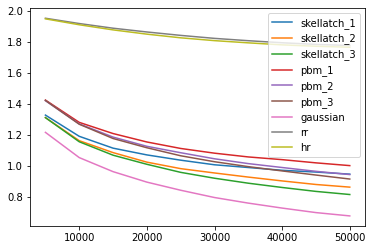

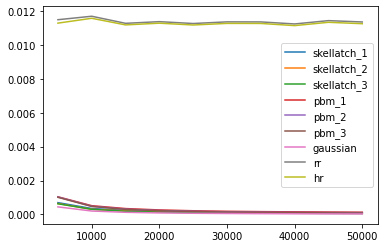

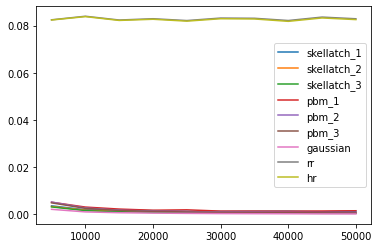

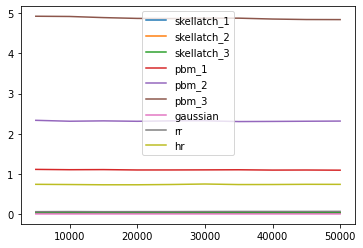

In [ ]:
#Testing script for comparison
k = 100000 #absz
rep = 10 #repetition time for each point
points = 10 # total number of points
step_sz = 5000 # step size between two points
init = 1 #initial step

for dist in ['Zipf']:
    print(dist)
    for eps in [2, 5, 10]:
        print(datetime.datetime.now())
        data = test(k,eps,rep,points,step_sz,init,dist,0,0)

In [ ]:
mechanisms = ['skellatch_1', 'skellatch_2', 'skellatch_3', 'pbm_1', 'pbm_2', 'pbm_3']
mechanisms_short = [ 'skellatch_1', 'skellatch_3','skellatch_2', 'gaussian', 'pbm_1', 'pbm_2', 'pbm_3']
legend = {
    'skellatch_1': 'Skellatch ({}k bits)'.format(100*9*16/1000),
    'skellatch_2': 'Skellatch ({}k bits)'.format(500*9*16/1000),
    'skellatch_3': 'Skellatch ({}k bits)'.format(300*9*16/1000),
    'pbm_1': 'pbm ({}k bits)'.format(100*9*16/1000),
    'pbm_2': 'pbm ({}k bits)'.format(500*9*16/1000),
    'pbm_3': 'pbm ({}k bits)'.format(300*9*16/1000),
    'gaussian': 'one-hot with Gaussian ({}M bits)'.format(k*15/1000000),
    'rr': 'RR ({} bits)'.format(int(np.log2(k))),
    'hr': 'HR ({} bits)'.format(int(np.log2(k)))
}

## Plot l_inf all mechanisms
plt.figure()
for mec in mechanisms:
  plt.plot(data['indicies'], data['linf_error'][mec], label = legend[mec])
  plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

#plt.xscale('log')
plt.xlabel('n (number of users)')
plt.ylabel( r'$\ell_\infty$ error')
plt.yscale('log')
plt.title(f'Zipf distrbution, d = {k//1000}k, $\epsilon =${eps})')

plt.savefig('/content/drive/MyDrive/skellatch_plots/skellatch_plot_all_d_{}_eps_{}_large_n_zipf_inf.png'.format(k//1000, eps), dpi=800, bbox_inches='tight')
plt.show()

## Plot l_inf Skellatch/Gaussian
plt.figure()
for mec in mechanisms_short:
  plt.plot(data['indicies'], data['linf_error'][mec], label = legend[mec])
  plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

#plt.xscale('log')
plt.xlabel('n (number of users)')
plt.ylabel( r'$\ell_\infty$ error')
plt.yscale('log')
plt.title(f'Zipf distrbution, d = {k//1000}k, $\epsilon =${eps})')

plt.savefig('/content/drive/MyDrive/skellatch_plots/skellatch_plot_short_d_{}_eps_{}_large_n_zipf_inf.png'.format(k//1000, eps), dpi=800, bbox_inches='tight')
plt.show()

NameError: ignored

# Test eps

In [ ]:
## Test eps

def test_eps(k, eps_list, rep, n, dist, encode_acc = 1, encode_mode = 0):

    print('Alphabet size:', k)
    print('Number of users:', n)
    print('Privacy levels:', eps_list)

    prob1 = generate_uniform_distribution(k)
    prob2 = generate_two_steps_distribution(k)
    prob3 = generate_Zipf_distribution(k,1.0)
    prob4 = generate_Dirichlet_distribution(k,1.0)
    prob5 = generate_geometric_distribution(k,0.8)

    prob_list = {
        'Uniform' : prob1,
        'Two_steps' : prob2,
        'Zipf' : prob3,
        'Dirchlet' : prob4,
        'Geometric' : prob5, 
        }
    #underlying distribution
    prob = prob_list[dist]
    
    #mechanisms = ['skellatch_1', 'skellatch_2', 'skellatch_3', 'pbm_1', 'pbm_2', 'pbm_3', 'gaussian', 'rr', 'hr']
    mechanisms = ['pbm_1', 'pbm_2', 'pbm_3', 'pbm_4', 'pbm_5', 'gaussian', 'rr', 'hr']
    

    l1_metrics = {}
    l2_metrics = {}
    linf_metrics = {}
    run_time = {}

    print('Generating theta table...')
    n_list = [n]
    d_list = [9*256, 9*1024, 9*2048, 9*4096, 9*8192]
    L_list = [511]
    theta_table = {}
    param_list = [(n, d, eps, L) for n in n_list for d in d_list for eps in eps_list for L in L_list]
    for param in param_list:
      theta_table[param] = get_pbm_theta(n=param[0], d=param[1], target_eps=param[2], m=param[3])

    for mec in mechanisms:
      l1_metrics[mec] = [0]*len(eps_list)
      l2_metrics[mec] = [0]*len(eps_list)
      linf_metrics[mec] = [0]*len(eps_list)
      run_time[mec] = [0]*len(eps_list)

    for eps_idx, eps in enumerate(eps_list):
        print('Epislon value:', eps)
        
        # Create mechanisms
        #subset = Subsetselection.Subsetselection(k,eps) #class for subset selection algorithm
        rappor = RR_RAPPOR.RAPPOR(k,eps) #class for RAPPOR
        rr = RR_RAPPOR.Randomized_Response(k, eps) #class for Randomized Response
        if encode_acc == 1:
            hr = k2k_hadamard.Hadamard_Rand_general(k,eps,1) #initialize hadamard response
        else:
            hr = k2k_hadamard.Hadamard_Rand_general(k,eps,0) #initialize hadamard response]
        #sk_1 = skellatch(k, eps, w=256, t=9)
        #sk_2 = skellatch(k, eps, w=1024, t=9)
        #sk_3 = skellatch(k, eps, w=2048, t=9)
        gauss = Gaussian(k, eps)
        pbm_1 = sketched_pbm(k, eps, L=511, w=256, t=9)
        pbm_2 = sketched_pbm(k, eps, L=511, w=1024, t=9)
        pbm_3 = sketched_pbm(k, eps, L=511, w=2048, t=9)
        pbm_4 = sketched_pbm(k, eps, L=511, w=4096, t=9)
        pbm_5 = sketched_pbm(k, eps, L=511, w=8192, t=9)

        
        pbm_1.theta_table = theta_table
        pbm_2.theta_table = theta_table
        pbm_3.theta_table = theta_table
        pbm_4.theta_table = theta_table
        pbm_5.theta_table = theta_table

        privatizers = {
        #'skellatch_1': sk_1,
        #'skellatch_2': sk_2,
        #'skellatch_3': sk_3,
        'gaussian': gauss,
        'rr': rr,
        'hr': hr,
        'pbm_1': pbm_1,
        'pbm_2': pbm_2,
        'pbm_3': pbm_3,
        'pbm_4': pbm_4,
        'pbm_5': pbm_5
        }

        l1_count = {}
        l2_count = {}
        linf_count = {}
        time_count = {}

        for mec in mechanisms:
          l1_count[mec] = 0
          l2_count[mec] = 0
          linf_count[mec] = 0
          time_count[mec] = 0
        
        for t in range(0,rep):
            #print(t)
            elements = range(0,k)
            in_list = np.random.choice(elements, n, p=prob) #input symbols
            true_hist,_ = np.histogram(in_list, np.arange(k+1))

            for mec in mechanisms:
              output = privatizers[mec].encode_string(in_list)
              start_time = timeit.default_timer()
              if mec in ['pbm_1', 'pbm_2', 'pbm_3', 'pbm_4', 'pbm_5']:
                hist_est = privatizers[mec].decode_string(output, n=n)
              else:
                hist_est = privatizers[mec].decode_string(output)
              if mec in ['gaussian', 'pbm_1', 'pbm_2', 'pbm_3', 'pbm_4', 'pbm_5']:
                hist_est = hist_est/n 
              time_count[mec] = time_count[mec] + timeit.default_timer() - start_time
              l1_count[mec] = l1_count[mec] + np.linalg.norm([a_i - b_i for a_i, b_i in zip(project_probability_simplex(hist_est), true_hist/n)], ord=1)
              l2_count[mec] = l2_count[mec] + np.linalg.norm([a_i - b_i for a_i, b_i in zip(project_probability_simplex(hist_est), true_hist/n)], ord=2)**2
              linf_count[mec] = linf_count[mec] + np.linalg.norm([a_i - b_i for a_i, b_i in zip(hist_est, true_hist/n)], ord=np.inf)

        # Dump metrics
        for mec in mechanisms:
          l1_metrics[mec][eps_idx] = l1_count[mec]/(float(rep))
          l2_metrics[mec][eps_idx] = l2_count[mec]/(float(rep))
          linf_metrics[mec][eps_idx] = linf_count[mec]/(float(rep))
          run_time[mec][eps_idx] = time_count[mec]/float(rep)

    plt.figure()
    for mec in mechanisms:
      plt.plot(eps_list, l1_metrics[mec], label = mec)  
    plt.legend()
    
    plt.figure()
    for mec in mechanisms:
      plt.plot(eps_list, l2_metrics[mec], label = mec)
    plt.legend()
    
    plt.figure()
    for mec in mechanisms:
      plt.plot(eps_list, linf_metrics[mec], label = mec)
    plt.legend()

    plt.figure()
    for mec in mechanisms:
      plt.plot(eps_list, run_time[mec], label = mec)
    plt.legend()

    time = datetime.datetime.now().strftime("%m_%d_%H_%M")

    #save all the data into a mat file with time stamp
    data = {
        'eps_list': eps_list,
        'time' : time,
        'absz' : k,
        'repetition' : rep,
        'l1_error': l1_metrics,
        'l2_error': l2_metrics,
        'linf_error': linf_metrics,
        'run_time': run_time,
        'prob': prob,
        'dist': dist
    }
    para = 'k_{}_n_{}_'.format(k, n)
    filename = 'Data/data_eps_' + dist + '_' + para + 'L_500_PBM_only' + time
    io.savemat(filename,data)
    return data

Zipf
2022-10-18 02:48:52.935278
Alphabet size: 100000
Number of users: 20000
Privacy levels: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Generating theta table...
Epislon value: 1
Epislon value: 2
Epislon value: 3
Epislon value: 4
Epislon value: 5
Epislon value: 6
Epislon value: 7
Epislon value: 8
Epislon value: 9
Epislon value: 10
Epislon value: 11
Epislon value: 12
Epislon value: 13
Epislon value: 14
Epislon value: 15


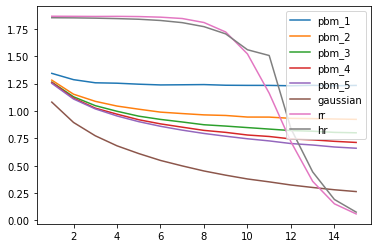

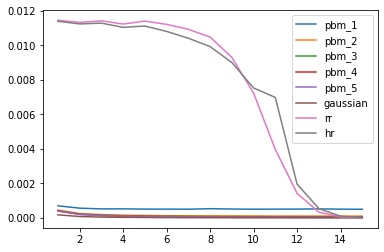

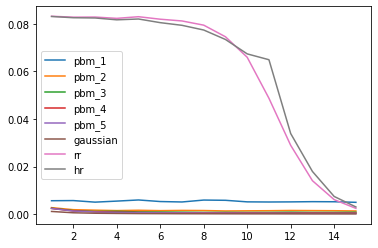

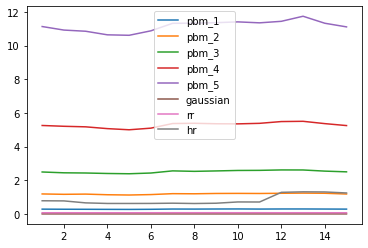

In [ ]:
#Testing script for comparison
k = 100000 #absz
n = 20000
rep = 15 #repetition time for each point
eps_list = np.arange(1, 16)

for dist in ['Zipf']:
    print(dist)
    print(datetime.datetime.now())
    data = test_eps(k, eps_list, rep, n, dist, encode_acc = 0, encode_mode = 0)
  

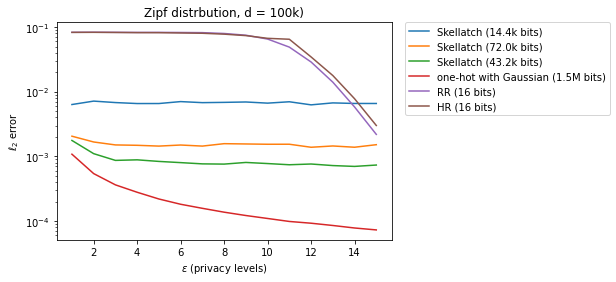

In [ ]:
## Plot l_2 all mechanisms
plt.figure()
mechanisms = ['skellatch_1', 'skellatch_2', 'skellatch_3', 'gaussian', 'rr', 'hr']
legend = {
    'skellatch_1': 'Skellatch ({}k bits)'.format(100*9*16/1000),
    'skellatch_2': 'Skellatch ({}k bits)'.format(500*9*16/1000),
    'skellatch_3': 'Skellatch ({}k bits)'.format(300*9*16/1000),
    'gaussian': 'one-hot with Gaussian ({}M bits)'.format(data['absz']*15/1000000),
    'rr': 'RR ({} bits)'.format(int(np.log2(k))),
    'hr': 'HR ({} bits)'.format(int(np.log2(k)))
}

k = data['absz'] 

for mec in mechanisms:
  plt.plot(data['eps_list'], data['linf_error'][mec], label = legend[mec])
  plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)


#plt.xscale('log')
plt.xlabel(r'$\varepsilon$ (privacy levels)')
plt.ylabel( r'$\ell_2$ error')
plt.yscale('log')
plt.title(data['dist'] + f' distrbution, d = {k//1000}k)')

#plt.savefig('/content/drive/MyDrive/skellatch_plots/skellatch_plot_all_d_{}_eps_{}_large_n_zipf_l2.png'.format(k//1000, eps), dpi=800, bbox_inches='tight')
plt.show()

